<a href="https://colab.research.google.com/github/sarique2003/Zeo_Tap/blob/main/Mohd_Sarique_Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import requests
from google.colab import drive

# the json files are uploaded in drive and being used after mounting
drive.mount('/content/drive')
drive_path = '/content/drive/MyDrive/Zeotap'

Mounted at /content/drive


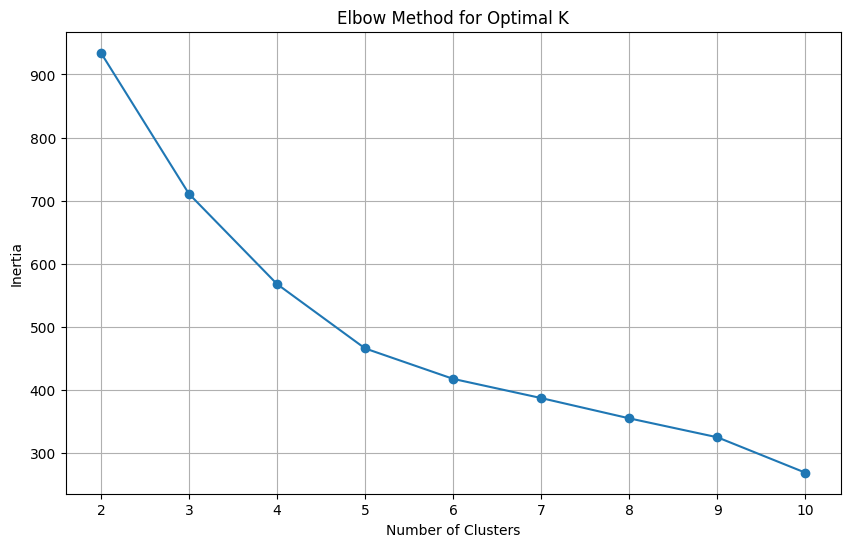

Davies-Bouldin Index: 1.372
Silhouette Score: 0.324


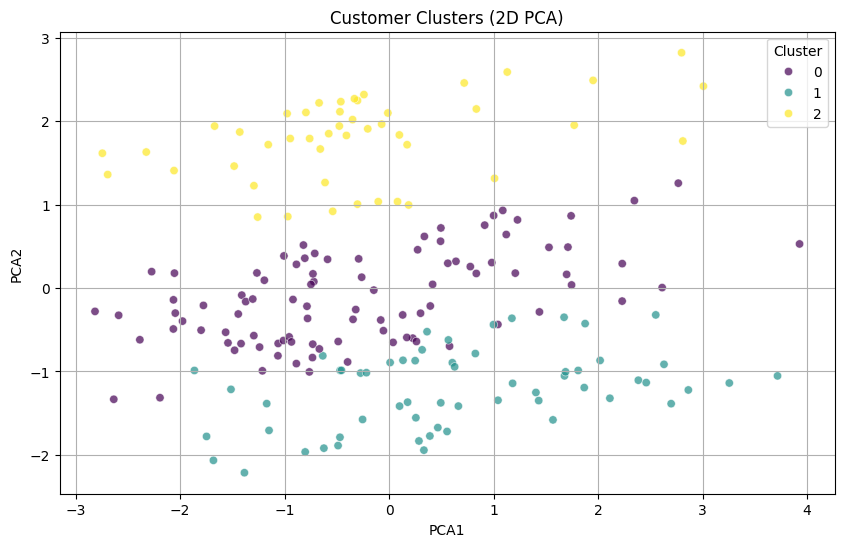

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import davies_bouldin_score, silhouette_score

# Load datasets
customers = pd.read_csv(f"{drive_path}/Customers.csv")
transactions = pd.read_csv(f"{drive_path}/Transactions.csv")

# Merge data to create customer profiles
merged_data = pd.merge(transactions, customers, on='CustomerID', how='inner')

# Feature engineering for customer profiles
customer_features = merged_data.groupby('CustomerID').agg({
    'TotalValue': 'sum',         # Total spend
    'Quantity': 'sum',           # Total quantity purchased
    'Region': 'first',           # Region
    'SignupDate': 'first'        # Signup date
}).reset_index()


customer_features['SignupDuration'] = (pd.Timestamp.today() - pd.to_datetime(customer_features['SignupDate'])).dt.days
customer_features.drop(columns=['SignupDate'], inplace=True)
customer_features = pd.get_dummies(customer_features, columns=['Region'], drop_first=True)
scaler = StandardScaler()
scaled_features = scaler.fit_transform(customer_features.drop(columns=['CustomerID']))

# Elbow method to determine optimal K
inertia = [
    KMeans(n_clusters=k, random_state=42, n_init='auto').fit(scaled_features).inertia_
    for k in range(2, 11)
]
plt.figure(figsize=(10, 6))
plt.plot(range(2, 11), inertia, marker='o')
plt.title("Elbow Method for Optimal K")
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia")
plt.grid()
plt.show()
optimal_k = 3
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init='auto')
customer_features['Cluster'] = kmeans.fit_predict(scaled_features)

# Evaluate clustering performance
db_index = davies_bouldin_score(scaled_features, customer_features['Cluster'])
silhouette_avg = silhouette_score(scaled_features, customer_features['Cluster'])
print(f"Davies-Bouldin Index: {db_index:.3f}")
print(f"Silhouette Score: {silhouette_avg:.3f}")

# PCA visualization
pca = PCA(n_components=2)
pca_result = pca.fit_transform(scaled_features)
customer_features['PCA1'], customer_features['PCA2'] = pca_result[:, 0], pca_result[:, 1]

plt.figure(figsize=(10, 6))
sns.scatterplot(data=customer_features, x='PCA1', y='PCA2', hue='Cluster', palette='viridis', alpha=0.7)
plt.title("Customer Clusters (2D PCA)")
plt.grid()
plt.show()